In [1]:
import numpy as np
import torch
import torch_geometric
import open3d as o3d
#utils
import h5py
import os
import dataclasses

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


## Utils

### Load data

In [17]:
from utils.data import load_h5_data, PairData, PCDDataset
from torch_geometric.loader import DataLoader as PyGLoader

### Viz

In [3]:
from utils.viz import viz_many_mpl

### Configs

In [4]:
@dataclasses.dataclass
class ModelConfig:
    num_point: int = 256 # number of points per sample
    up_ratio: int = 4 # upsampling ratio
    dilation: int = 2 # dilation in DenseGCN 
    num_neighbours: int = 20 # num neighbours in DenseGCN 
    n_idgcn_blocks: int = 2 # number of inception dense blocks
    channels: int = 32 # number of channels for gcn
    n_dgcn_blocks: int = 3 # number of DenseGCNBlocks in the DenseGCN
    
    
@dataclasses.dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 10
    optimizer = "adam"
    lr = .001
    beta = .9
    

opts = ModelConfig()
train_config = TrainConfig()

# Data

In [5]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")

In [6]:
dataset = PCDDataset(data_path, opts, 5)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 13800 samples


In [10]:
data = next(iter(dataset))
data_cloud, gt_cloud = data.pos_s, data.pos_t

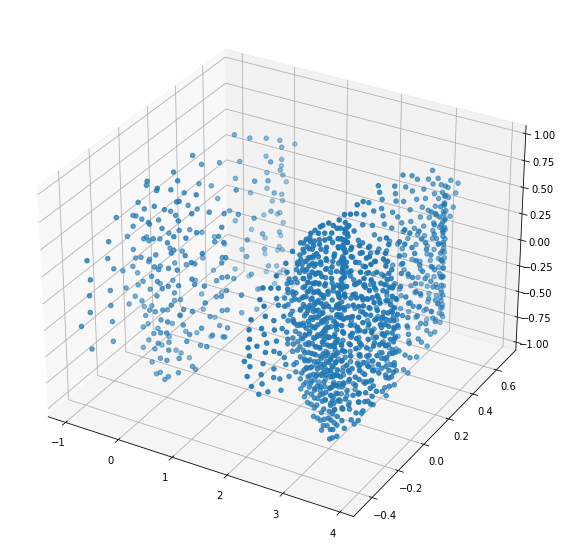

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([data_cloud, gt_cloud], ax = ax)

# Training

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
from pugcn_lib import PUGCN

In [14]:
dataset = PCDDataset(data_path, opts, 10)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 6900 samples


In [15]:
train_perc = .8
trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)])

In [18]:
# trainloader = DataLoader(trainset, batch_size=64)
# valloader = DataLoader(valset, batch_size=64, shuffle=False)
trainloader = PyGLoader(trainset, batch_size=8, follow_batch=['pos_s', 'pos_t'])
valloader = PyGLoader(valset, batch_size=8, shuffle=False, follow_batch = ['pos_s', 'pos_t'])


In [21]:
pugcn =  PUGCN(channels = opts.channels, k = opts.num_neighbours, r = opts.up_ratio, n_idgcn_blocks=opts.n_idgcn_blocks, n_dgcn_blocks=opts.n_dgcn_blocks).to(device)

loss_fn = loss_fn = ChamferLoss()
optimizer = torch.optim.Adam(params = pugcn.parameters(), lr = train_config.lr)

In [22]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

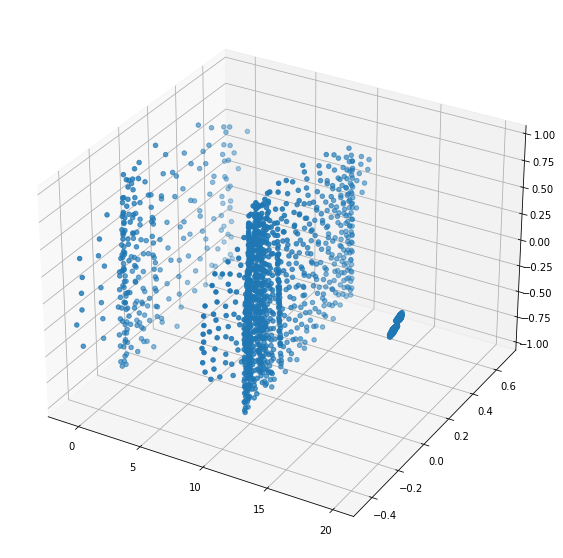

In [23]:
pred = pugcn(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

viz_many_mpl([data_cloud, gt_cloud, pred], d = 10, ax = ax)

In [25]:
def train(model, trainloader, loss_fn, optimizer):
    
    total_loss = 0.
    for d in (t:= tqdm(trainloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None
                    
        # get batch and target dimesnions since chamfer loss will need rehsaping
        b, nq = p_batch.max().item() + 1, q.shape[0] 
        
        # Train step
        optimizer.zero_grad()
        
        pred = model(p, batch = p_batch)
        d1, d2, _, _ = loss_fn(pred.reshape(b, nq // b, 3), q.reshape(b, nq // b, 3))
        loss = d1.mean() + d2.mean()
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss


@torch.no_grad()
def evaluate(model, valloader, loss_fn):
    
    total_loss = 0.
    for d in (t:= tqdm(valloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None
                    
        # get batch and target dimesnions since chamfer loss will need rehsaping
        b, nq = p_batch.max().item() + 1, q.shape[0] 
        
        pred = model(p, batch = p_batch)
        d1, d2, _, _ = loss_fn(pred.reshape(b, nq // b, 3), q.reshape(b, nq // b, 3))
        loss = d1.mean() + d2.mean()
        
        total_loss+=loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss
    

In [26]:
l = train(pugcn, trainloader, loss_fn, optimizer)

  0%|          | 0/690 [00:00<?, ?it/s]

In [27]:
idx = np.random.choice(len(valset))
dv = valset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [28]:
pred = pugcn(sample.to(device)).cpu().detach().numpy()
pred

array([[-3.7157986e-01,  7.2292984e-05, -4.9620345e-02],
       [ 2.5053543e-01,  1.4555052e-02,  3.9749146e-03],
       [-3.2220402e-01, -3.3359878e-02, -7.5857669e-02],
       ...,
       [-4.6377625e-02,  1.1303142e-01,  3.8486046e-01],
       [ 1.1490550e-01, -1.3021684e-01, -8.0573714e-01],
       [-7.4028268e-02,  8.4167503e-02,  4.3705225e-01]], dtype=float32)

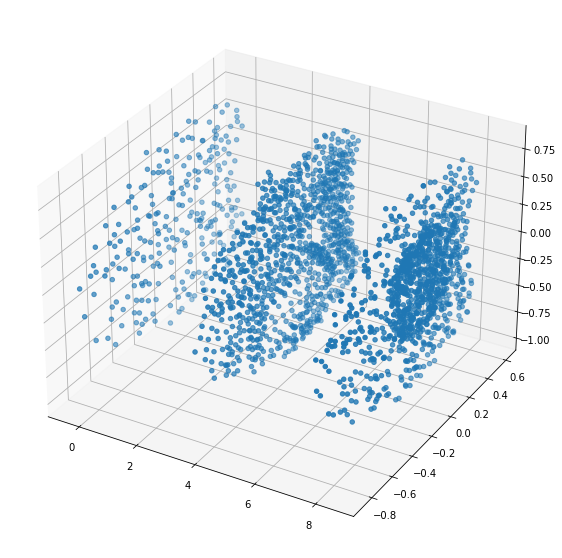

In [29]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([sample, gt, pred], d = 4, ax = ax)

In [214]:
valloader

In [216]:
l = evaluate(pugcn, valloader, loss_fn)
print(l)

  0%|          | 0/173 [00:00<?, ?it/s]

1.3365176753140986
